# DeepWeeds - Image Classification - Using ResNet50 Model

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import shutil

seed = 679
tf.random.set_seed(seed)

2024-02-27 03:37:44.469295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 03:37:44.469401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 03:37:44.616001: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].groupby(by='Species').count().T

Species,Chinee apple,Lantana,Negative,Parkinsonia,Parthenium,Prickly acacia,Rubber vine,Siam weed,Snake weed
Label,1125,1064,9106,1031,1022,1062,1009,1074,1016


In [5]:
label2id = data_info[['Species','Label']].groupby(by='Species').min().to_dict()['Label']
id2label = {label2id[i]:i for i in label2id}
id2label

{0: 'Chinee apple',
 1: 'Lantana',
 8: 'Negative',
 2: 'Parkinsonia',
 3: 'Parthenium',
 4: 'Prickly acacia',
 5: 'Rubber vine',
 6: 'Siam weed',
 7: 'Snake weed'}

In [6]:
low_data_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels with very low data
low_data_labels

array([0, 1, 7, 6, 4, 3, 5, 2])

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [7]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 2 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

# skfold = StratifiedKFold()
# kSplits = skfold.split(data_info['Filename'], y=data_info['Label'])
# for index in range(skfold.get_n_splits()):
#     train_index, test_index = next(kSplits)
#     if index == split_index:
#         break
        
# # trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# # train_data = pd.DataFrame({"Filename":trax,"label":tray})

# # trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# # valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# # test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 3 out of 5 folds
-------------------------------------------------



In [8]:
## Using Folds Used in The DeepWeeds Paper
train_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/train_subset{}.csv'.format(split_index)) ## for GoogleColab
train_data.rename(columns={"Label":"label"}, inplace=True)

valid_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/val_subset{}.csv'.format(split_index)) ## for GoogleColab
valid_data.rename(columns={"Label":"label"}, inplace=True)
test_data = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/test_subset{}.csv'.format(split_index)) ## for GoogleColab
test_data.rename(columns={"Label":"label"}, inplace=True)

print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
print("Train Data\n--------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("Validation Data\n--------\n",valid_data.groupby(by='label').count().T, "\tTotal:", valid_data.shape)
print("Test Data\n--------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  676  638  619  613  637  605  644  610  5464 	Total: (10506, 2)
Validation Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  212  206  205  213  202  215  203  1821 	Total: (3502, 2)
Test Data
--------
 label       0    1    2    3    4    5    6    7     8
Filename  225  213  206  204  212  202  215  203  1821 	Total: (3501, 2)


# Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)

In [9]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['Filename']
        label = row['label']

        source = os.path.join(source_dir,filename)
        
        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [10]:
from sklearn.utils import class_weight

def getWeightedClass(data, power=1, col="Label"):

    class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(data_info[col]),
                                                 y=data_info[col])

    return  { label: pow(class_weights[label],power) for label in range(len(class_weights)) }

getWeightedClass(data_info)

{0: 1.729283950617284,
 1: 1.8284252297410193,
 2: 1.8869490246793836,
 3: 1.9035659926070885,
 4: 1.8318685917555975,
 5: 1.9280916198656535,
 6: 1.8114007862611214,
 7: 1.9148075240594926,
 8: 0.21364423945139957}

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()
    
    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP
        
        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)
        
        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)
        
        false_rate.append((fP_Rate,accuracy))
    
    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()          
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()      
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]
    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=45 #'vertical'
    )
    #cmd.plot()
    plt.show()
    
def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# Creating Dateset ImageGenerator

In [12]:
IMG_SIZE=(256,256,3)
oversampling = 0 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds_9c" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Validation Data
organize_data_to_directory(valid_data, source_dir=input_dir, target_dir=validation_dir)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [13]:
train_generator = getDatasetGenerators(
      train_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=False
)

validation_generator = getDatasetGenerators(
      validation_dir,
      batch_size=16,
      label_mode='categorical',
      image_size = IMG_SIZE[:2],
      shuffle=True
)

Found 10506 files belonging to 9 classes.
Found 3501 files belonging to 9 classes.
Found 3502 files belonging to 9 classes.


## Displaying Sample Images

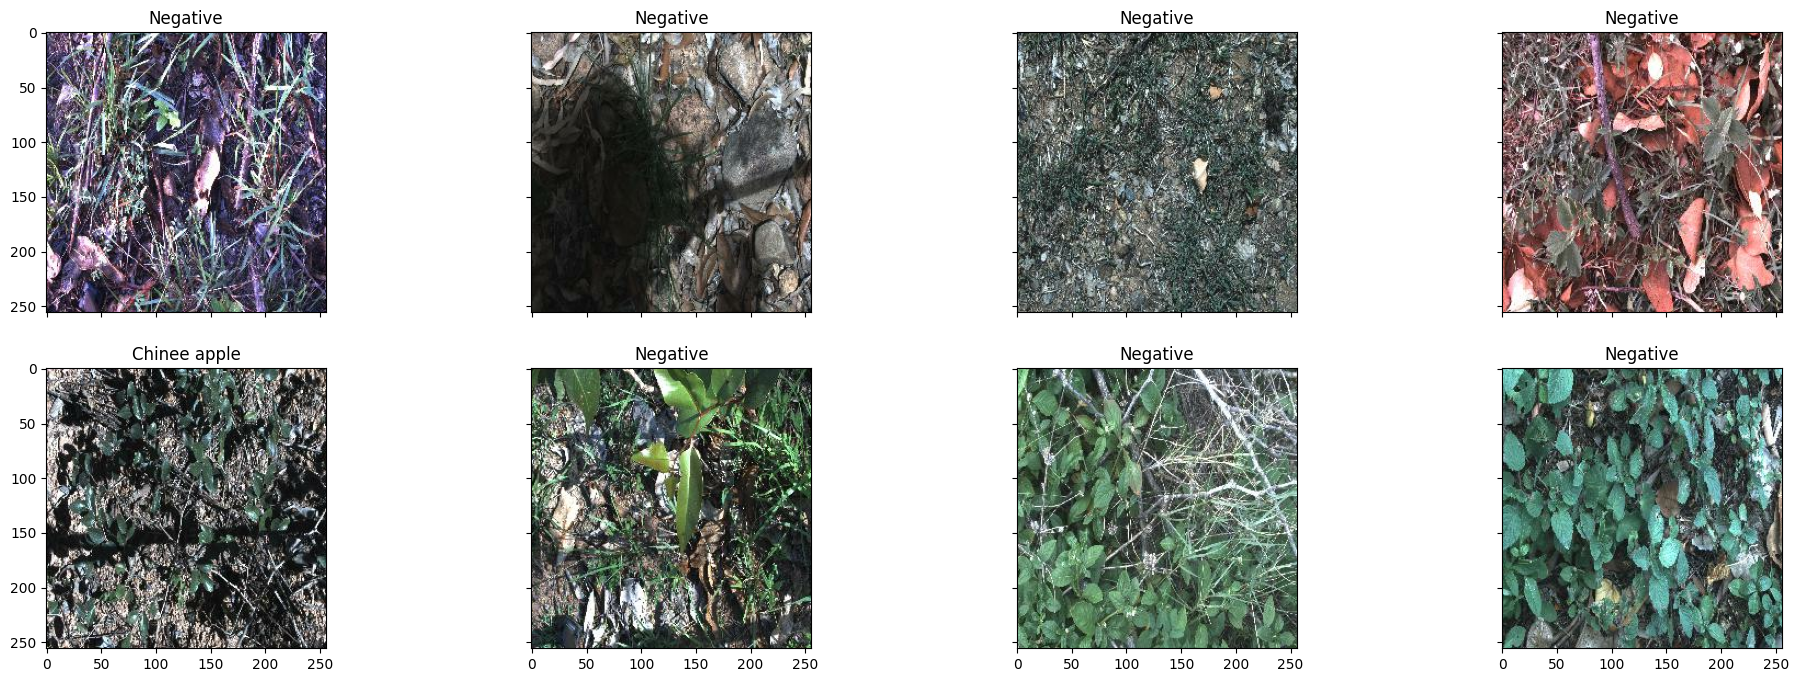

In [14]:
#image visualization

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# ResNet50

In [15]:
# prompt: code to implement resnet

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2, resnet_v2

def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE)

    # PreProcess the input.
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Resizing(224, 224)(x)
    
    ## Augmentation
    x = layers.RandomBrightness(0.25, (0, 1),seed=seed)(x)
    x = layers.RandomContrast(0.1, seed=seed)(x)
    x = layers.GaussianDropout(0.05, seed=seed)(x)
    x = layers.RandomFlip(seed=seed)(x)
    x = layers.RandomRotation(0.5, seed=seed)(x)
    x = layers.RandomTranslation(0.2, 0.2, seed=seed)(x)
    x = layers.RandomZoom(0.2, 0.2, seed=seed)(x)

    # Pass the input through the pre-trained ResNet50 model.
    x = base_model(x, training=train_resnet)    
    x = layers.Dropout(0.2)(x) 
    
    ## Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    
    # Add a final output layer with 10 units and softmax activation.
    outputs = layers.Dense(9, activation='softmax', name='Classifier')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name='DeepWeeds-ResNet50')
    return model

## Trial 1

In [16]:
model = buildResNetModel(train_resnet=True)
model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "DeepWeeds-ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_brightness (RandomB  (None, 224, 224, 3)       0         
 rightness)                                                      
                                                                 
 random_contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                 

In [17]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


2024-02-27 03:40:27.589418: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709005233.143800      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


657/657 [==============================] - 116s 127ms/step - loss: 1.1050 - accuracy: 0.6194 - val_loss: 0.7730 - val_accuracy: 0.7302
Epoch 2/100
657/657 [==============================] - 80s 121ms/step - loss: 0.8161 - accuracy: 0.7111 - val_loss: 0.6693 - val_accuracy: 0.7656
Epoch 3/100
657/657 [==============================] - 80s 121ms/step - loss: 0.7259 - accuracy: 0.7453 - val_loss: 0.5918 - val_accuracy: 0.8035
Epoch 4/100
657/657 [==============================] - 80s 121ms/step - loss: 0.6672 - accuracy: 0.7645 - val_loss: 0.5515 - val_accuracy: 0.8175
Epoch 5/100
657/657 [==============================] - 79s 121ms/step - loss: 0.6195 - accuracy: 0.7814 - val_loss: 0.5354 - val_accuracy: 0.8218
Epoch 6/100
657/657 [==============================] - 79s 121ms/step - loss: 0.6022 - accuracy: 0.7885 - val_loss: 0.5055 - val_accuracy: 0.8295
Epoch 7/100
657/657 [==============================] - 79s 121ms/step - loss: 0.5798 - accuracy: 0.7959 - val_loss: 0.4949 - val_accura

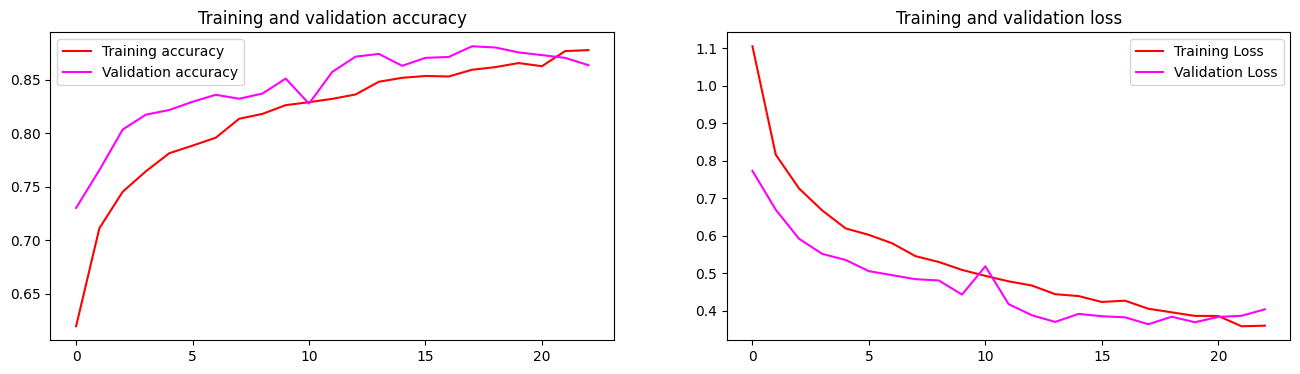

CPU times: user 30min 54s, sys: 1min 23s, total: 32min 18s
Wall time: 31min 7s


In [18]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Model")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
219/219 [==============================] - 8s 35ms/step - loss: 0.3764 - accuracy: 0.8732
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81720   0.67556   0.73966       225
       Lantana    0.78761   0.83962   0.81279       212
   Parkinsonia    0.97423   0.91748   0.94500       206
    Parthenium    0.85644   0.84390   0.85012       205
Prickly acacia    0.81328   0.92019   0.86344       213
   Rubber vine    0.91892   0.84158   0.87855       202
     Siam weed    0.89894   0.78605   0.83871       215
    Snake weed    0.79048   0.81773   0.80387       203
      Negative    0.89679   0.92092   0.90870      1821

      accuracy                        0.87664      3502
     macro avg    0.86154   0.84034   0.84898      3502
  weighted avg    0.87743   0.87664   0.87587      3502


                False Positive Rate  Accuracy
Chinee apple               0.010375  0.675556
Lantana                    0.014590  0.839623
Parkinsonia                0.001517  0.917476
Parthenium                 0.008796  0.843902
Prickly acacia    

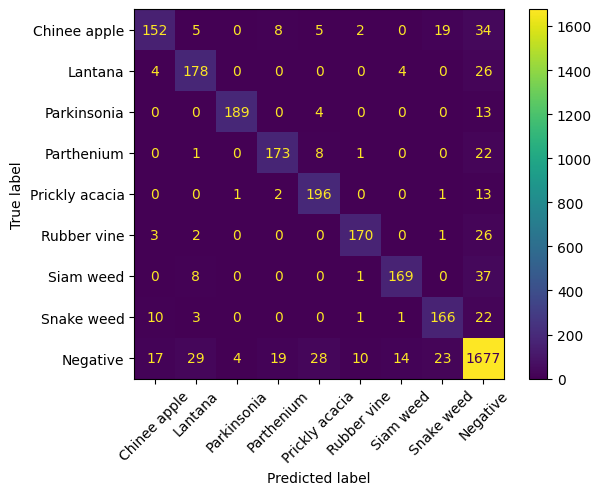

In [19]:
a, b = eval_model(model, validation_generator)

## Trial 2

Epoch 1/100


2024-02-27 04:12:05.108076: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 106s 123ms/step - loss: 0.3238 - accuracy: 0.8906 - val_loss: 0.3365 - val_accuracy: 0.8866
Epoch 2/100
657/657 [==============================] - 80s 121ms/step - loss: 0.3009 - accuracy: 0.9002 - val_loss: 0.2978 - val_accuracy: 0.9001
Epoch 3/100
657/657 [==============================] - 80s 121ms/step - loss: 0.2802 - accuracy: 0.9024 - val_loss: 0.2941 - val_accuracy: 0.9058
Epoch 4/100
657/657 [==============================] - 80s 121ms/step - loss: 0.2781 - accuracy: 0.9041 - val_loss: 0.2832 - val_accuracy: 0.9103
Epoch 5/100
657/657 [==============================] - 79s 121ms/step - loss: 0.2555 - accuracy: 0.9139 - val_loss: 0.2920 - val_accuracy: 0.9063
Epoch 6/100
657/657 [==============================] - 80s 121ms/step - loss: 0.2593 - accuracy: 0.9128 - val_loss: 0.2835 - val_accuracy: 0.9055
Epoch 7/100
657/657 [==============================] - 80s 121ms/step - loss: 0.2419 - accuracy: 0.9179 - val_loss: 0.2766 - val_accura

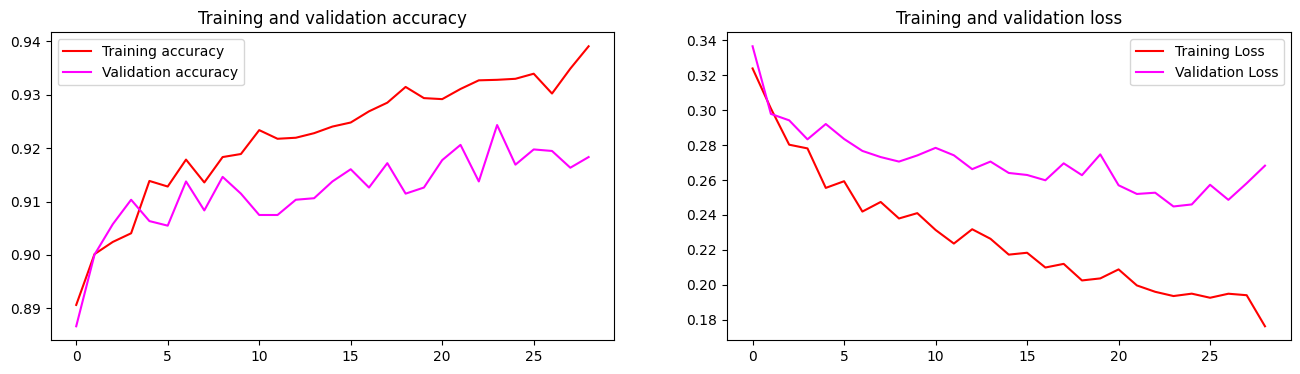

CPU times: user 38min 54s, sys: 1min 39s, total: 40min 33s
Wall time: 38min 57s


In [20]:
%%time
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-5,  weight_decay=3e-3),
          metrics=['accuracy'])

# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history2.history)

model.evaluate
219/219 [==============================] - 8s 36ms/step - loss: 0.2575 - accuracy: 0.9178
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.81818   0.80000   0.80899       225
       Lantana    0.85135   0.89151   0.87097       212
   Parkinsonia    0.96552   0.95146   0.95844       206
    Parthenium    0.87907   0.92195   0.90000       205
Prickly acacia    0.85590   0.92019   0.88688       213
   Rubber vine    0.90995   0.95050   0.92978       202
     Siam weed    0.95522   0.89302   0.92308       215
    Snake weed    0.86598   0.82759   0.84635       203
      Negative    0.93968   0.93245   0.93605      1821

      accuracy                        0.91376      3502
     macro avg    0.89343   0.89874   0.89561      3502
  weighted avg    0.91437   0.91376   0.91381      3502


                False Positive Rate  Accuracy
Chinee apple               0.012206  0.800000
Lantana                    0.010030  0.891509
Parkinsonia                0.002124  0.951456
Parthenium                 0.007886  0.921951
Prickly acacia    

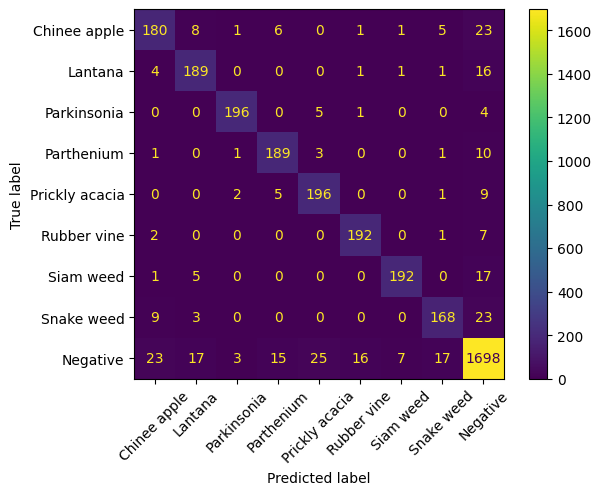

In [21]:
a, b = eval_model(model, validation_generator)

### Trial 3

Epoch 1/100


2024-02-27 04:51:43.635789: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 107s 123ms/step - loss: 0.1938 - accuracy: 0.9339 - val_loss: 0.2558 - val_accuracy: 0.9158
Epoch 2/100
657/657 [==============================] - 80s 122ms/step - loss: 0.1960 - accuracy: 0.9304 - val_loss: 0.2481 - val_accuracy: 0.9140
Epoch 3/100
657/657 [==============================] - 80s 121ms/step - loss: 0.1914 - accuracy: 0.9332 - val_loss: 0.2547 - val_accuracy: 0.9172
Epoch 4/100
657/657 [==============================] - 80s 121ms/step - loss: 0.1909 - accuracy: 0.9328 - val_loss: 0.2525 - val_accuracy: 0.9172
Epoch 5/100
657/657 [==============================] - 80s 121ms/step - loss: 0.1927 - accuracy: 0.9343 - val_loss: 0.2541 - val_accuracy: 0.9169
Epoch 6/100
657/657 [==============================] - 80s 121ms/step - loss: 0.1873 - accuracy: 0.9338 - val_loss: 0.2529 - val_accuracy: 0.9215
Epoch 7/100
657/657 [==============================] - 80s 122ms/step - loss: 0.1921 - accuracy: 0.9357 - val_loss: 0.2608 - val_accura

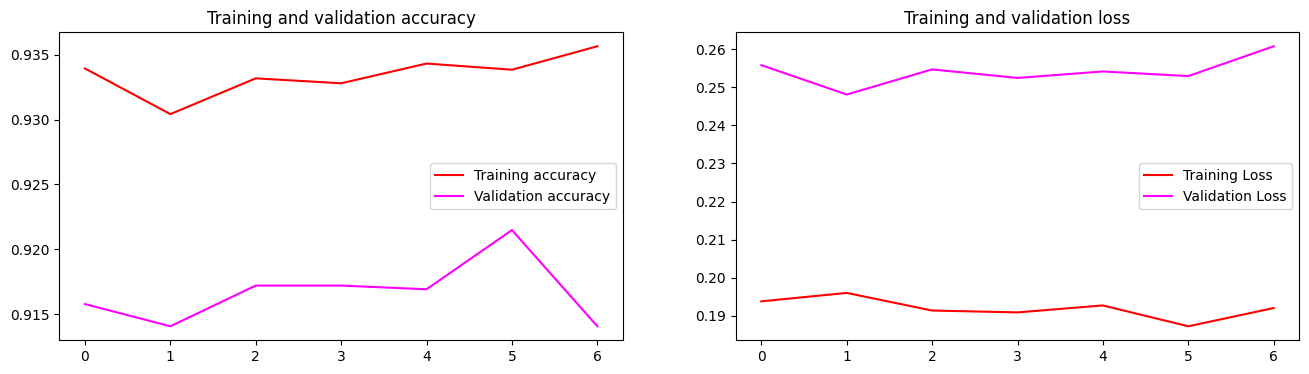

CPU times: user 9min 45s, sys: 25.6 s, total: 10min 11s
Wall time: 9min 48s


In [22]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Increasing Class-Weights",weights)

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=5e-6,  weight_decay=3e-4),
  metrics=['accuracy'])

# Train the model
history3 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      #class_weight=weights
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history3.history)

model.evaluate
219/219 [==============================] - 8s 36ms/step - loss: 0.2567 - accuracy: 0.9175
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.83575   0.76889   0.80093       225
       Lantana    0.89100   0.88679   0.88889       212
   Parkinsonia    0.96618   0.97087   0.96852       206
    Parthenium    0.86636   0.91707   0.89100       205
Prickly acacia    0.89238   0.93427   0.91284       213
   Rubber vine    0.92195   0.93564   0.92875       202
     Siam weed    0.93868   0.92558   0.93208       215
    Snake weed    0.86170   0.79803   0.82864       203
      Negative    0.94159   0.94728   0.94443      1821

      accuracy                        0.92033      3502
     macro avg    0.90173   0.89827   0.89956      3502
  weighted avg    0.91984   0.92033   0.91984      3502


                False Positive Rate  Accuracy
Chinee apple               0.010375  0.768889
Lantana                    0.006991  0.886792
Parkinsonia                0.002124  0.970874
Parthenium                 0.008796  0.917073
Prickly acacia    

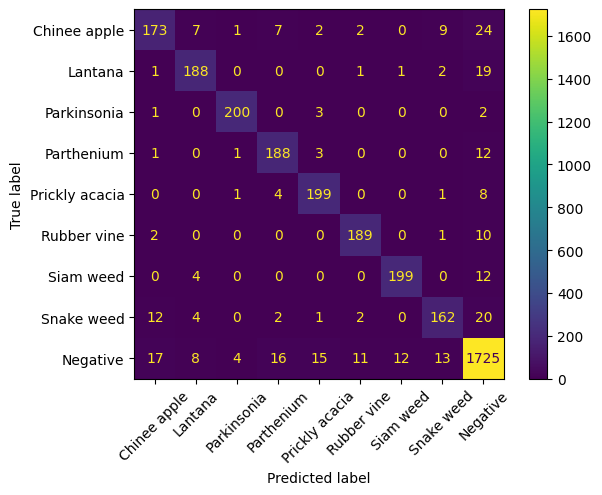

In [23]:
a, b = eval_model(model, validation_generator)

## Trial 4

Freezing layer resnet50v2
Epoch 1/100


2024-02-27 05:02:05.691159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inDeepWeeds-ResNet50/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 37s 51ms/step - loss: 0.2866 - accuracy: 0.9027 - val_loss: 0.2074 - val_accuracy: 0.9358
Epoch 2/100
657/657 [==============================] - 32s 49ms/step - loss: 0.2861 - accuracy: 0.9023 - val_loss: 0.2076 - val_accuracy: 0.9360
Epoch 3/100
657/657 [==============================] - 33s 49ms/step - loss: 0.2887 - accuracy: 0.9034 - val_loss: 0.2078 - val_accuracy: 0.9358
Epoch 4/100
657/657 [==============================] - 33s 49ms/step - loss: 0.2882 - accuracy: 0.9026 - val_loss: 0.2080 - val_accuracy: 0.9358
Epoch 5/100
657/657 [==============================] - 33s 49ms/step - loss: 0.2777 - accuracy: 0.9061 - val_loss: 0.2082 - val_accuracy: 0.9363
Epoch 6/100
657/657 [==============================] - 33s 49ms/step - loss: 0.2806 - accuracy: 0.9078 - val_loss: 0.2084 - val_accuracy: 0.9360
Epoch 6: early stopping
Saving the Checkpoint


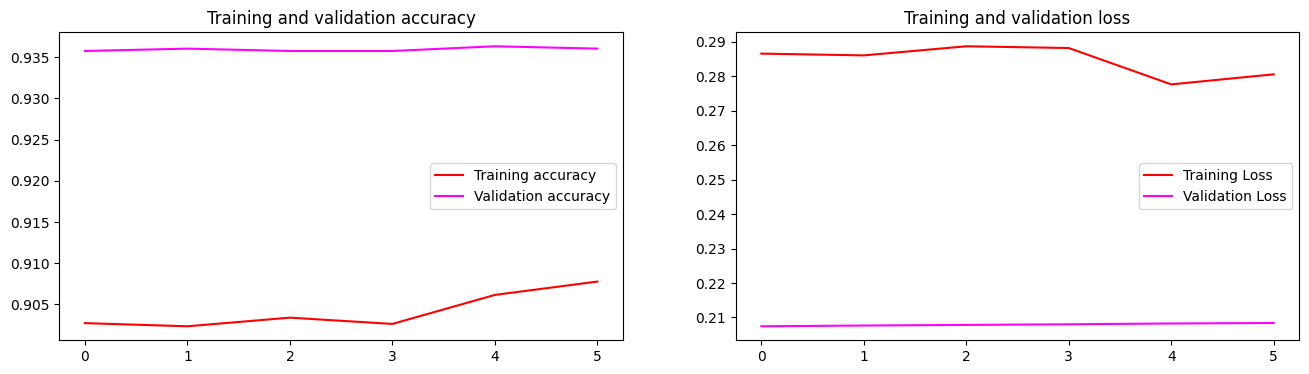

CPU times: user 3min 19s, sys: 15.7 s, total: 3min 35s
Wall time: 3min 21s


In [24]:
%%time
for layer in model.layers:
    if layer.name == 'resnet50v2':
        print("Freezing layer", layer.name)
        layer.trainable = False
        
model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=1e-4),
  metrics=['accuracy'])

# Train the model
history4 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping]
    )

print("Saving the Checkpoint")
model.save("DeepWeeds-ResNet50-Model.keras")

# Plot training results
plot_loss_acc(history4.history)

# Evaluations

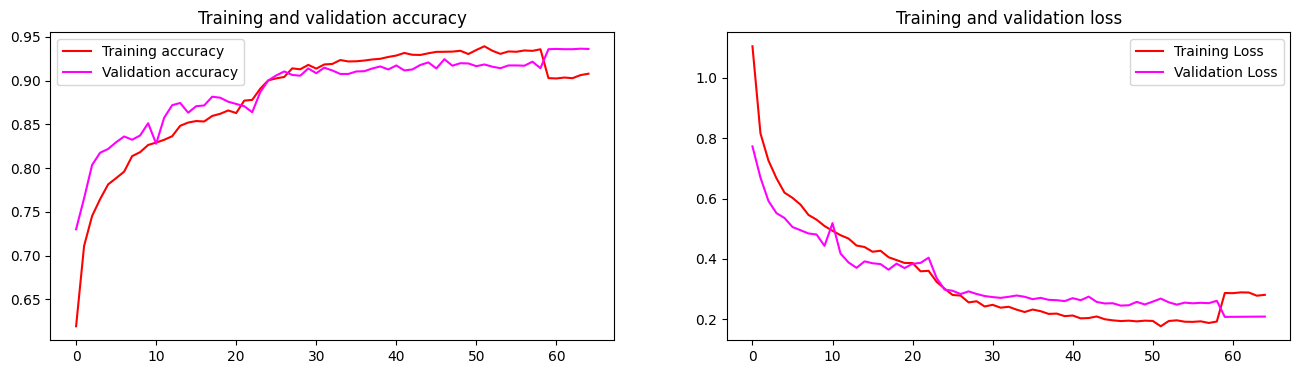

In [25]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])
    history[key].extend(history3.history[key])
    history[key].extend(history4.history[key])
    

plot_loss_acc(history)

model.evaluate
219/219 [==============================] - 7s 34ms/step - loss: 0.2074 - accuracy: 0.9358
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85845   0.83556   0.84685       225
       Lantana    0.88341   0.92925   0.90575       212
   Parkinsonia    0.95694   0.97087   0.96386       206
    Parthenium    0.88532   0.94146   0.91253       205
Prickly acacia    0.86325   0.94836   0.90380       213
   Rubber vine    0.94231   0.97030   0.95610       202
     Siam weed    0.97129   0.94419   0.95755       215
    Snake weed    0.88832   0.86207   0.87500       203
      Negative    0.96527   0.94618   0.95563      1821

      accuracy                        0.93575      3502
     macro avg    0.91273   0.92758   0.91967      3502
  weighted avg    0.93666   0.93575   0.93590      3502


                False Positive Rate  Accuracy
Chinee apple               0.009460  0.835556
Lantana                    0.007903  0.929245
Parkinsonia                0.002731  0.970874
Parthenium                 0.007583  0.941463
Prickly acacia    

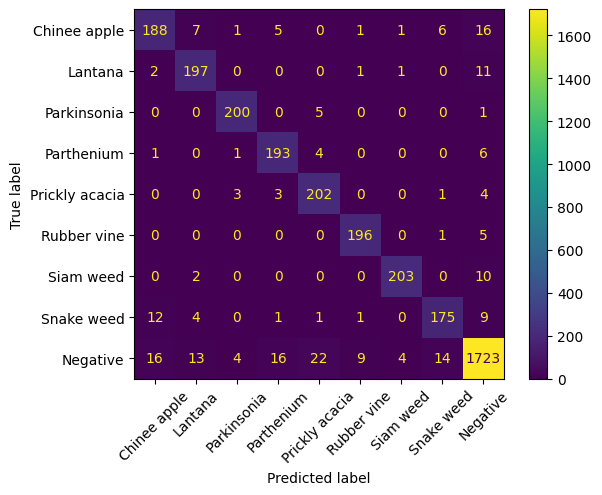

'Threshold = 0.1111111119389534'

In [26]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

thresholds = []
for i in range(len(a)):
    n_label = prediction_argmax(b[i])
    ap_label = np.argmax(b[i])
    a_label = a[i]

    if(n_label == a_label):
        thresholds.append(b[n_label])


rand_guess = np.mean(thresholds)
"Threshold = {}".format(rand_guess)

## Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
219/219 [==============================] - 9s 39ms/step - loss: 0.2066 - accuracy: 0.9317
model.predict


  0%|          | 0/219 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.85654   0.90222   0.87879       225
       Lantana    0.88235   0.91549   0.89862       213
   Parkinsonia    0.90667   0.99029   0.94664       206
    Parthenium    0.85778   0.94608   0.89977       204
Prickly acacia    0.87611   0.93396   0.90411       212
   Rubber vine    0.94089   0.94554   0.94321       202
     Siam weed    0.93182   0.95349   0.94253       215
    Snake weed    0.89055   0.88177   0.88614       203
      Negative    0.97189   0.93026   0.95062      1821

      accuracy                        0.93173      3501
     macro avg    0.90162   0.93323   0.91671      3501
  weighted avg    0.93377   0.93173   0.93216      3501


                False Positive Rate  Accuracy
Chinee apple               0.010379  0.902222
Lantana                    0.007908  0.915493
Parkinsonia                0.006373  0.990291
Parthenium                 0.009706  0.946078
Prickly acacia    

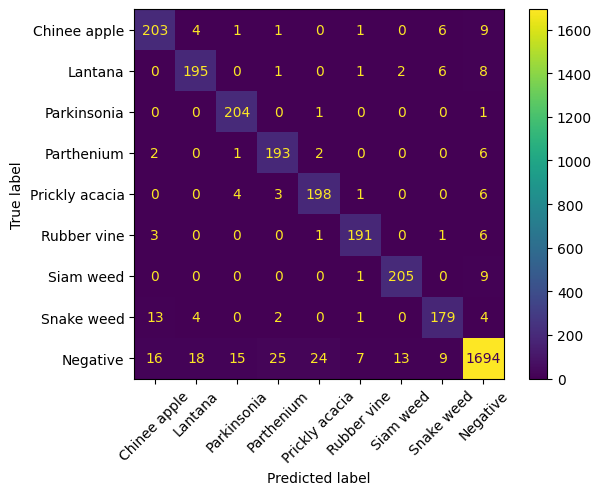

In [27]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

## Random Guess Threshold
> As applied by the paper DeepWeeds

Evaluation with Random Guess - As applied by the paper DeepWeeds   
--------------------------------------------------------------------
Evaluation Metrics

                precision    recall  f1-score   support

  Chinee apple    0.76667   0.92000   0.83636       225
       Lantana    0.81967   0.93897   0.87527       213
   Parkinsonia    0.90667   0.99029   0.94664       206
    Parthenium    0.84889   0.93627   0.89044       204
Prickly acacia    0.82591   0.96226   0.88889       212
   Rubber vine    0.93171   0.94554   0.93857       202
     Siam weed    0.93578   0.94884   0.94226       215
    Snake weed    0.89055   0.88177   0.88614       203
      Negative    0.98139   0.89786   0.93777      1821

      accuracy                        0.91831      3501
     macro avg    0.87858   0.93576   0.90471      3501
  weighted avg    0.92529   0.91831   0.91958      3501


                False Positive Rate  Accuracy
Chinee apple               0.019231  0.920000
Lantana            

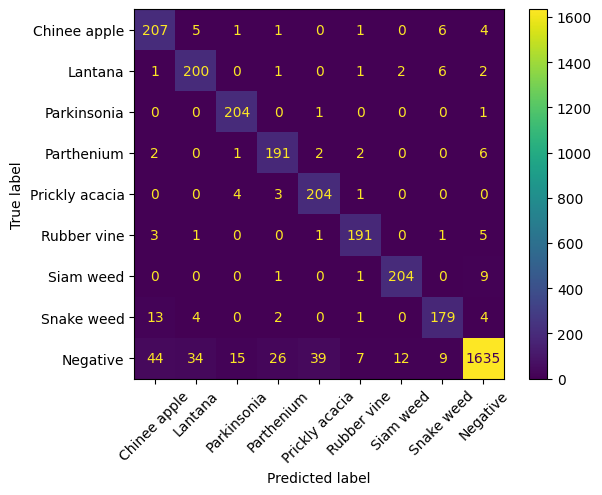

In [28]:
print("Evaluation with Random Guess - As applied by the paper DeepWeeds \
  \n--------------------------------------------------------------------")
printStats(a,b,rand_guess)

In [29]:
shutil.rmtree(base_dir)